In [ ]:
import pulp
import math

# =============================================================================
# 1. VERİ VE PARAMETRELER (MAKALE ALTYAPISI)
# =============================================================================

# Lokasyonlar
LOCATIONS = {
    'Muni_1': (100, 950), 'Muni_2': (250, 900), 'Muni_3': (150, 600),
    'Muni_4': (400, 200), 'Muni_5': (420, 150),
    'Sort_Blue_1': (120, 850), 'Sort_Blue_2': (410, 180),
    'Sort_CRD_1': (140, 820), 'Sort_CRD_2': (300, 500), 'Sort_CRD_3': (430, 170),
    'Port_1': (130, 880), 'Port_2': (310, 520), 'Port_3': (450, 160),
    'Recycler_1': (400, 100), 'Recycler_2': (460, 80), 'Recycler_3': (420, 120),
    'Landfill_1': (500, 50)
}

# Kümeler
P_SETS = ['BlueBox', 'CRD'] # Karışık Atıklar
M_SETS = ['Paper', 'Plastic', 'Glass', 'Metal', 'Wood', 'Aggregates', 'Residue'] # Ayrıştırılmış Malzemeler

C_SETS = [k for k in LOCATIONS if 'Muni' in k]
K_SETS = [k for k in LOCATIONS if 'Port' in k]
S_SETS = [k for k in LOCATIONS if 'Sort' in k]
R_SETS = [k for k in LOCATIONS if 'Recycler' in k]
L_SETS = [k for k in LOCATIONS if 'Landfill' in k]

# 1. Arz Parametresi (q_pc)
q_pc = {}
for p in P_SETS:
    for c in C_SETS:
        if c in ['Muni_1', 'Muni_2']: q_pc[(p, c)] = 10000 # Kuzey (Yoğun)
        else: q_pc[(p, c)] = 2000

# 2. Dönüşüm Oranları Parametresi (Beta) - (Çöp üretimi dahil)
beta_mp = {
    ('BlueBox', 'Paper'): 0.35, ('BlueBox', 'Plastic'): 0.25, ('BlueBox', 'Glass'): 0.20,
    ('BlueBox', 'Metal'): 0.05, ('BlueBox', 'Residue'): 0.15, ('BlueBox', 'Wood'): 0.00, ('BlueBox', 'Aggregates'): 0.00,

    ('CRD', 'Paper'): 0.00, ('CRD', 'Plastic'): 0.05, ('CRD', 'Glass'): 0.00,
    ('CRD', 'Metal'): 0.05, ('CRD', 'Residue'): 0.10, ('CRD', 'Wood'): 0.50, ('CRD', 'Aggregates'): 0.30
}

# 3. Kapasite Parametreleri (Theta)
theta_s = {s: (15000 if 'Blue' in s else 25000) for s in S_SETS}
theta_k = {k: 50000 for k in K_SETS}

# Maliyet Parametreleri
HANDLING_COST = 7.0
EXT_ROAD = 0.059     # Dışsal Maliyet (Kara)
EXT_MARITIME = 0.021 # Dışsal Maliyet (Deniz)

def get_distance(loc1, loc2):
    c1, c2 = LOCATIONS[loc1], LOCATIONS[loc2]
    return math.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2)

def calculate_costs(u, v, mode, is_handling=False):
    dist = get_distance(u, v)

    # Finansal Maliyet (C_fin)
    if mode == 'road':
        cost = 0; rem = dist
        tiers = [(0.9, 1.639), (8.1, 0.327), (20.0, 0.297), (35.0, 0.123), (95.0, 0.097)]
        for r, p_val in tiers:
            if rem <= 0: break
            d = min(rem, r); cost += d * p_val; rem -= d
        if rem > 0: cost += rem * 0.097
        fin = cost
    else:
        fin = dist * 0.065

    if is_handling: fin += HANDLING_COST

    # Dışsal Maliyet (C_ext) - S3 için
    ext = dist * (EXT_ROAD if mode=='road' else EXT_MARITIME)

    return {'fin': fin, 'ext': ext, 'dist': dist, 'mode': mode}

# --- LINK OLUŞTURMA ---
links = {}
# Toplama (Muni -> Sort/Port)
for c in C_SETS:
    for s in S_SETS:
        waste = "BlueBox" if "Blue" in s else "CRD"
        links[('pcs', waste, c, s)] = calculate_costs(c, s, 'road')
for p in P_SETS:
    for c in C_SETS:
        for k in K_SETS: links[('pck', p, c, k)] = calculate_costs(c, k, 'road', True)

# Ara Transfer (Port -> Sort/Port)
for k in K_SETS:
    for s in S_SETS:
        waste = "BlueBox" if "Blue" in s else "CRD"
        links[('pks', waste, k, s)] = calculate_costs(k, s, 'road', True)
for p in P_SETS:
    for k1 in K_SETS:
        for k2 in K_SETS:
            if k1!=k2: links[('pkk', p, k1, k2)] = calculate_costs(k1, k2, 'sea')

# Dağıtım (Sort -> Recycler/Landfill/Port)
for m in M_SETS:
    for s in S_SETS:
        if m == 'Residue': # Çöp -> Landfill
            for l in L_SETS: links[('msl', m, s, l)] = calculate_costs(s, l, 'road')
            for k in K_SETS: links[('msk', m, s, k)] = calculate_costs(s, k, 'road', True)
        else: # Malzeme -> Recycler
            for r in R_SETS: links[('msr', m, s, r)] = calculate_costs(s, r, 'road')
            for k in K_SETS: links[('msk', m, s, k)] = calculate_costs(s, k, 'road', True)

# Dağıtım (Port -> Recycler/Landfill/Port)
for m in M_SETS:
    for k1 in K_SETS:
        for k2 in K_SETS:
            if k1!=k2: links[('mkk', m, k1, k2)] = calculate_costs(k1, k2, 'sea')
    for k in K_SETS:
        if m == 'Residue':
            for l in L_SETS: links[('mkl', m, k, l)] = calculate_costs(k, l, 'road', True)
        else:
            for r in R_SETS: links[('mkr', m, k, r)] = calculate_costs(k, r, 'road', True)

# =============================================================================
# 2. MODEL ÇÖZÜCÜ (SADECE S1, S2, S3)
# =============================================================================

def solve_model(scenario):
    # Model Tanımlama
    model = pulp.LpProblem(f"Scenario_{scenario}", pulp.LpMinimize)

    # Karar Değişkenleri (Sürekli değişkenler - LP)
    x = {}
    for key in links:
        x[key] = pulp.LpVariable(f"x_{key}", 0, cat='Continuous')

    # Senaryo Ayarları
    use_maritime = (scenario != 'S1') # S1 hariç deniz serbest
    use_external = (scenario == 'S3') # Sadece S3'te dışsal maliyet var

    # 1. Amaç Fonksiyonu
    # Minimize Z = Finansal (+ Dışsal eğer S3 ise)
    obj = []
    for key, var in x.items():
        cost = links[key]['fin']
        if use_external:
            cost += links[key]['ext']
        obj.append(var * cost)
    model += pulp.lpSum(obj)

    # 2. Kısıtlar

    # Denizyolu Kısıtlaması (S1 için)
    if not use_maritime:
        for key in x:
            if links[key]['mode'] == 'sea':
                model += x[key] == 0

    # Kısıt (2): Arzı Karşılama (Supply Constraint)
    for p in P_SETS:
        for c in C_SETS:
            outflow = pulp.lpSum(x.get(('pcs', p, c, s), 0) for s in S_SETS) + \
                      pulp.lpSum(x.get(('pck', p, c, k), 0) for k in K_SETS)
            model += (outflow == q_pc[(p, c)])

    # Kısıt (3): Liman Denge - Karışık Atık (Flow Conservation Mixed)
    for p in P_SETS:
        for k in K_SETS:
            inflow = pulp.lpSum(x.get(('pck', p, c, k), 0) for c in C_SETS) + \
                     pulp.lpSum(x.get(('pkk', p, kp, k), 0) for kp in K_SETS if kp!=k)
            outflow = pulp.lpSum(x.get(('pkk', p, k, kn), 0) for kn in K_SETS if kn!=k) + \
                      pulp.lpSum(x.get(('pks', p, k, s), 0) for s in S_SETS)
            model += (inflow == outflow)

    # Kısıt (4) ve Dönüşüm: Ayrıştırma Merkezi Denges (Sorting Mass Balance)
    for s in S_SETS:
        # Girdi (Input) Hesabı
        total_in = 0
        for p in P_SETS:
            # Karayolu + Multimodal Girişler
            in_p = pulp.lpSum(x.get(('pcs', p, c, s), 0) for c in C_SETS) + \
                   pulp.lpSum(x.get(('pks', p, k, s), 0) for k in K_SETS)
            total_in += in_p

            # Çıktı (Output) Hesabı: Beta ile dönüşüm
            for m in M_SETS:
                generated_amount = in_p * beta_mp[(p, m)]

                # Bu 'm' malzemesi nereye gidiyor? (Recycler, Landfill, Port)
                out_m = pulp.lpSum(x.get(('msr', m, s, r), 0) for r in R_SETS) + \
                        pulp.lpSum(x.get(('msl', m, s, l), 0) for l in L_SETS) + \
                        pulp.lpSum(x.get(('msk', m, s, k), 0) for k in K_SETS)

                # Malzeme bazlı denge: Üretilen = Gönderilen
                model += (generated_amount == out_m)

        # Kapasite Kısıtı (Constraint 5 in Paper)
        model += (total_in <= theta_s[s])

    # Kısıt (6): Liman Denge - Ayrışmış Malzeme (Flow Conservation Sorted)
    for m in M_SETS:
        for k in K_SETS:
            inflow = pulp.lpSum(x.get(('msk', m, s, k), 0) for s in S_SETS) + \
                     pulp.lpSum(x.get(('mkk', m, kp, k), 0) for kp in K_SETS if kp!=k)
            outflow = pulp.lpSum(x.get(('mkk', m, k, kn), 0) for kn in K_SETS if kn!=k) + \
                      pulp.lpSum(x.get(('mkl', m, k, l), 0) for l in L_SETS) + \
                      pulp.lpSum(x.get(('mkr', m, k, r), 0) for r in R_SETS)
            model += (inflow == outflow)

    # Kısıt (7): Liman Kapasitesi
    for k in K_SETS:
        thru = pulp.lpSum(x.get(('pck', p, c, k), 0) for c in C_SETS for p in P_SETS) + \
               pulp.lpSum(x.get(('msk', m, s, k), 0) for s in S_SETS for m in M_SETS)
        model += (thru <= theta_k[k])

    model.solve(pulp.PULP_CBC_CMD(msg=False))
    return model, x

# =============================================================================
# 3. RAPORLAMA
# =============================================================================

def print_flow_details(x):
    print("\n  --- AKIŞ ÖZETİ ---")
    # Sadece 0'dan büyük akışları göster
    for key, var in x.items():
        if var.varValue > 0.1:
            u, v = key[-2], key[-1]
            print(f"    {u} -> {v} ({links[key]['mode']}): {var.varValue:,.0f}")

def report_results(scenario, model, x):
    print(f"\n{'='*40}\nSENARYO: {scenario}\n{'='*40}")

    fin_cost = 0; ext_cost = 0; sea_km = 0
    for key, var in x.items():
        v = var.varValue
        if v and v > 0.1:
            fin_cost += v * links[key]['fin']
            ext_cost += v * links[key]['ext']
            if 'sea' in links[key]['mode']:
                sea_km += v * links[key]['dist']

    total_obj = fin_cost + (ext_cost if scenario == 'S3' else 0)

    print(f"  Finansal Maliyet: ${fin_cost:,.0f}")
    print(f"  Dışsal Maliyet:   ${ext_cost:,.0f}")
    print(f"  TOPLAM AMAÇ:      ${total_obj:,.0f}")
    print(f"  Deniz Kullanımı:  {sea_km:,.0f} ton*km")

    # Tesis Kullanımı
    print("  [Tesis Kullanımı]")
    for s in S_SETS:
        used = 0
        for p in P_SETS:
            used += sum(x.get(('pcs', p, c, s), pulp.LpVariable("d",0)).varValue or 0 for c in C_SETS)
            used += sum(x.get(('pks', p, k, s), pulp.LpVariable("d",0)).varValue or 0 for k in K_SETS)
        print(f"    {s}: {used:,.0f} / {theta_s[s]}")

    return fin_cost, ext_cost

# ÇALIŞTIRMA
r1 = report_results("S1 (Road)", *solve_model("S1"))
r2 = report_results("S2 (Multimodal)", *solve_model("S2"))
r3 = report_results("S3 (Sustainable)", *solve_model("S3"))

print("\n" + "="*60)
print(f"{'Senaryo':<15} | {'Finansal ($)':<15} | {'Dışsal ($)':<15}")
print("-" * 60)
print(f"{'S1':<15} | {r1[0]:,.0f} | {r1[1]:,.0f}")
print(f"{'S2':<15} | {r2[0]:,.0f} | {r2[1]:,.0f}")
print(f"{'S3':<15} | {r3[0]:,.0f} | {r3[1]:,.0f}")


SENARYO: S1 (Road)
  Finansal Maliyet: $4,094,941
  Dışsal Maliyet:   $2,011,414
  TOPLAM AMAÇ:      $4,094,941
  Deniz Kullanımı:  0 ton*km
  [Tesis Kullanımı]
    Sort_Blue_1: 0 / 15000
    Sort_Blue_2: 20,000 / 15000
    Sort_CRD_1: 0 / 25000
    Sort_CRD_2: 0 / 25000
    Sort_CRD_3: 20,000 / 25000

SENARYO: S2 (Multimodal)
  Finansal Maliyet: $3,026,936
  Dışsal Maliyet:   $1,036,974
  TOPLAM AMAÇ:      $3,026,936
  Deniz Kullanımı:  23,483,456 ton*km
  [Tesis Kullanımı]
    Sort_Blue_1: 0 / 15000
    Sort_Blue_2: 0 / 15000
    Sort_CRD_1: 0 / 25000
    Sort_CRD_2: 0 / 25000
    Sort_CRD_3: 0 / 25000

SENARYO: S3 (Sustainable)
  Finansal Maliyet: $3,038,752
  Dışsal Maliyet:   $895,263
  TOPLAM AMAÇ:      $3,038,752
  Deniz Kullanımı:  31,516,345 ton*km
  [Tesis Kullanımı]
    Sort_Blue_1: 0 / 15000
    Sort_Blue_2: 0 / 15000
    Sort_CRD_1: 0 / 25000
    Sort_CRD_2: 0 / 25000
    Sort_CRD_3: 0 / 25000

Senaryo         | Finansal ($)    | Dışsal ($)     
--------------------------

In [ ]:
import pulp
import math
import pandas as pd
import numpy as np

# =============================================================================
# 1. VERİ SETİ
# =============================================================================

LOCATIONS = {
    # --- KAYNAKLAR ---
    'Muni_1': (100, 950), 'Muni_2': (250, 900), 'Muni_3': (150, 600),
    'Muni_4': (400, 200), 'Muni_5': (420, 150),
    # --- AYRIŞTIRMA ---
    'Sort_Blue_1': (120, 850), 'Sort_Blue_2': (410, 180),
    'Sort_CRD_1': (140, 820), 'Sort_CRD_2': (300, 500), 'Sort_CRD_3': (430, 170),
    # --- LİMANLAR ---
    'Port_1': (130, 880), 'Port_2': (310, 520), 'Port_3': (450, 160),
    # --- HEDEFLER ---
    'Recycler_1': (400, 100), 'Recycler_2': (460, 80), 'Recycler_3': (420, 120),
    'Landfill_1': (500, 50)
}

P_SETS = ['BlueBox', 'CRD']
# Residue (Çöp) malzemesi ekli
M_SETS = ['Paper', 'Plastic', 'Glass', 'Metal', 'Wood', 'Aggregates', 'Residue']

C_SETS = [k for k in LOCATIONS if 'Muni' in k]
K_SETS = [k for k in LOCATIONS if 'Port' in k]
R_SETS = [k for k in LOCATIONS if 'Recycler' in k]
L_SETS = [k for k in LOCATIONS if 'Landfill' in k]
S_BLUE = [k for k in LOCATIONS if 'Sort_Blue' in k]
S_CRD  = [k for k in LOCATIONS if 'Sort_CRD' in k]
S_SETS = S_BLUE + S_CRD

# --- PARAMETRELER ---
q_pc = {}
for p in P_SETS:
    for c in C_SETS:
        if c in ['Muni_1', 'Muni_2']: q_pc[(p, c)] = 10000
        else: q_pc[(p, c)] = 2000

# Beta oranları (%10-15 Çöp üretecek şekilde)
beta_mp = {
    ('BlueBox', 'Paper'): 0.35, ('BlueBox', 'Plastic'): 0.25, ('BlueBox', 'Glass'): 0.20, ('BlueBox', 'Metal'): 0.05,
    ('BlueBox', 'Wood'): 0.00,  ('BlueBox', 'Aggregates'): 0.00, ('BlueBox', 'Residue'): 0.15,

    ('CRD', 'Paper'): 0.00,     ('CRD', 'Plastic'): 0.05,     ('CRD', 'Glass'): 0.00,     ('CRD', 'Metal'): 0.05,
    ('CRD', 'Wood'): 0.50,      ('CRD', 'Aggregates'): 0.30,  ('CRD', 'Residue'): 0.10
}

theta_s = {}
for s in S_BLUE: theta_s[s] = 15000
for s in S_CRD:  theta_s[s] = 25000
theta_k = {'Port_1': 50000, 'Port_2': 50000, 'Port_3': 50000}
d_mr = {(m, r): 100000 for m in M_SETS for r in R_SETS}

# --- S4 VE GENEL PARAMETRELER ---
CARBON_TAX_RATE = 50.0
MAX_TIME_HOURS = 48.0
MIN_SEA_LOAD = 1000.0
EMISSION_QUOTA = 12000.0
SAFETY_MARGIN = 0.90
MIN_UTILIZATION = 0.40

SPEED_ROAD = 60.0; SPEED_SEA = 25.0; HANDLING_TIME = 12.0
EMIS_FACTOR_ROAD = 0.00010; EMIS_FACTOR_SEA = 0.00002

# =============================================================================
# 2. MALİYET VE VERİ HESAPLAMA
# =============================================================================

def get_distance(loc1, loc2):
    c1, c2 = LOCATIONS[loc1], LOCATIONS[loc2]
    return math.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2)

def calculate_road_cost(dist):
    cost = 0; rem = dist
    tiers = [(0.9, 1.639), (8.1, 0.327), (20.0, 0.297), (35.0, 0.123), (95.0, 0.097)]
    for r, p in tiers:
        if rem <= 0: break
        d = min(rem, r); cost += d * p; rem -= d
    if rem > 0: cost += rem * 0.097
    return cost

def calculate_maritime_cost(dist):
    return dist * 0.065

HANDLING_COST = 7.0; EXT_ROAD = 0.059; EXT_MARITIME = 0.021

def get_cost_data(u, v, mode, is_handling=False):
    dist = get_distance(u, v)
    fin = calculate_road_cost(dist) if mode=='road' else calculate_maritime_cost(dist)
    if is_handling: fin += HANDLING_COST
    ext = dist * (EXT_ROAD if mode=='road' else EXT_MARITIME)
    emis = dist * (EMIS_FACTOR_ROAD if mode=='road' else EMIS_FACTOR_SEA)
    speed = SPEED_ROAD if mode=='road' else SPEED_SEA
    time = dist / speed
    if mode == 'sea': time += HANDLING_TIME
    if is_handling: time += 1.0
    return {'dist': dist, 'fin': fin, 'ext': ext, 'emis': emis, 'time': time, 'mode': mode}

# --- LİNKLERİ OLUŞTUR (Residue Mantığı İle) ---
links = {}
for c in C_SETS:
    for s in S_BLUE: links[('pcs', 'BlueBox', c, s)] = get_cost_data(c, s, 'road')
    for s in S_CRD:  links[('pcs', 'CRD', c, s)]     = get_cost_data(c, s, 'road')
for p in P_SETS:
    for c in C_SETS:
        for k in K_SETS: links[('pck', p, c, k)] = get_cost_data(c, k, 'road', True)
for k in K_SETS:
    for s in S_BLUE: links[('pks', 'BlueBox', k, s)] = get_cost_data(k, s, 'road', True)
    for s in S_CRD:  links[('pks', 'CRD', k, s)]     = get_cost_data(k, s, 'road', True)
for p in P_SETS:
    for k1 in K_SETS:
        for k2 in K_SETS:
            if k1!=k2: links[('pkk', p, k1, k2)] = get_cost_data(k1, k2, 'sea')

# Tesisten Çıkış (Kısıtlamalı)
for m in M_SETS:
    for s in S_SETS:
        if m == 'Residue':
             for l in L_SETS: links[('msl', m, s, l)] = get_cost_data(s, l, 'road')
             for k in K_SETS: links[('msk', m, s, k)] = get_cost_data(s, k, 'road', True)
        else:
             for r in R_SETS: links[('msr', m, s, r)] = get_cost_data(s, r, 'road')
             for k in K_SETS: links[('msk', m, s, k)] = get_cost_data(s, k, 'road', True)

# Limandan Çıkış (Kısıtlamalı)
for m in M_SETS:
    for k1 in K_SETS:
        for k2 in K_SETS:
            if k1!=k2: links[('mkk', m, k1, k2)] = get_cost_data(k1, k2, 'sea')
    for k in K_SETS:
        if m == 'Residue':
            for l in L_SETS: links[('mkl', m, k, l)] = get_cost_data(k, l, 'road', True)
        else:
            for r in R_SETS: links[('mkr', m, k, r)] = get_cost_data(k, r, 'road', True)

# =============================================================================
# 3. MODEL ÇÖZÜCÜ
# =============================================================================

def solve_model(scenario):
    model = pulp.LpProblem(f"Scenario_{scenario}", pulp.LpMinimize)
    allow_maritime = (scenario in ['S2', 'S3', 'S4'])
    use_external = (scenario == 'S3'); is_s4 = (scenario == 'S4')
    x = {}; y = {}
    for key in links:
        x[key] = pulp.LpVariable(f"x_{key}", 0, cat='Continuous')
        if is_s4 and links[key]['mode'] == 'sea': y[key] = pulp.LpVariable(f"y_{key}", cat='Binary')

    if not allow_maritime:
        for key in x:
            if key[0] in ['pkk', 'mkk']: model += x[key] == 0

    obj = []
    for key, var in x.items():
        cost = links[key]['fin']
        if use_external: cost += links[key]['ext']
        cost += links[key]['emis'] * CARBON_TAX_RATE # Her senaryo için vergi
        obj.append(var * cost)
    model += pulp.lpSum(obj)

    # --- KISITLAR ---

    # 4 numaralı kısıt (Supply)
    for p in P_SETS:
        for c in C_SETS:
            out = pulp.lpSum(x.get(('pcs', p, c, s), 0) for s in S_SETS) + \
                  pulp.lpSum(x.get(('pck', p, c, k), 0) for k in K_SETS)
            model += (out == q_pc[(p, c)])

    # 5 numaralı kısıt (Port Balance - Mixed Waste)
    for p in P_SETS:
        for k in K_SETS:
            inflow = pulp.lpSum(x.get(('pck', p, c, k), 0) for c in C_SETS) + \
                     pulp.lpSum(x.get(('pkk', p, kp, k), 0) for kp in K_SETS if kp!=k)
            outflow = pulp.lpSum(x.get(('pkk', p, k, kn), 0) for kn in K_SETS if kn!=k) + \
                      pulp.lpSum(x.get(('pks', p, k, s), 0) for s in S_SETS)
            model += (inflow == outflow)

    # 6 numaralı kısıt (Port Balance - Sorted Materials)
    for m in M_SETS:
        for k in K_SETS:
            inflow = pulp.lpSum(x.get(('msk', m, s, k), 0) for s in S_SETS) + \
                     pulp.lpSum(x.get(('mkk', m, kp, k), 0) for kp in K_SETS if kp!=k)
            outflow = pulp.lpSum(x.get(('mkk', m, k, kn), 0) for kn in K_SETS if kn!=k) + \
                      pulp.lpSum(x.get(('mkl', m, k, l), 0) for l in L_SETS) + \
                      pulp.lpSum(x.get(('mkr', m, k, r), 0) for r in R_SETS)
            model += (inflow == outflow)

    # Mass Balance (Transformation at Sorting Centers)
    for s in S_SETS:
        for m in M_SETS:
            input_sum = 0
            for p in P_SETS:
                total_in_p = pulp.lpSum(x.get(('pcs', p, c, s), 0) for c in C_SETS) + \
                             pulp.lpSum(x.get(('pks', p, k, s), 0) for k in K_SETS)
                input_sum += total_in_p * beta_mp[(p, m)]
            output_sum = pulp.lpSum(x.get(('msr', m, s, r), 0) for r in R_SETS) + \
                         pulp.lpSum(x.get(('msl', m, s, l), 0) for l in L_SETS) + \
                         pulp.lpSum(x.get(('msk', m, s, k), 0) for k in K_SETS)
            model += (input_sum == output_sum)

    # Sorting Capacity (S4: Min %40, Max %90)
    for s in S_SETS:
        total_in = 0
        for p in P_SETS:
            total_in += pulp.lpSum(x.get(('pcs', p, c, s), 0) for c in C_SETS) + \
                        pulp.lpSum(x.get(('pks', p, k, s), 0) for k in K_SETS)
        limit_up = theta_s[s]
        if is_s4: limit_up *= SAFETY_MARGIN
        model += (total_in <= limit_up)
        if is_s4:
            limit_down = theta_s[s] * MIN_UTILIZATION
            model += (total_in >= limit_down)

    # Port Capacity (GÜNCELLENDİ: Dinamik Akış-Kapasite Dengesi Kısıtı içine taşındı)
    # for k in K_SETS:
    #     thru = pulp.lpSum(x.get(('pck', p, c, k), 0) for c in C_SETS for p in P_SETS) + \
    #            pulp.lpSum(x.get(('msk', m, s, k), 0) for s in S_SETS for m in M_SETS)
    #     model += (thru <= theta_k[k])

    # --- S4 KISITLARI ---
    if is_s4:
        for key in links:
            if links[key]['mode'] == 'sea' and links[key]['time'] > MAX_TIME_HOURS: model += x[key] == 0
        BIG_M = 1000000
        for key in y:
            model += x[key] <= BIG_M * y[key]; model += x[key] >= MIN_SEA_LOAD * y[key]
        tot_em = pulp.lpSum(x[key] * links[key]['emis'] for key in x)
        model += (tot_em <= EMISSION_QUOTA)

    # YENİ BİRLEŞTİRİLMİŞ KISIT: Dinamik Akış-Kapasite Dengesi
    # Bu döngü hem akışın dengede olmasını (giriş=çıkış)
    # hem de bu dengenin kapasite limitleri içinde kalmasını sağlar.
    for k in K_SETS:
        limit_up = theta_k[k] * SAFETY_MARGIN      # Üst Sınır (S4 Kısıtı)
        limit_down = theta_k[k] * MIN_UTILIZATION  # Alt Sınır (Verimlilik)

        # Giriş Akışları Toplamı
        inflow_sum = pulp.lpSum(x.get(('pck', p, c, k), 0) for c in C_SETS for p in P_SETS) + \
                     pulp.lpSum(x.get(('msk', m, s, k), 0) for s in S_SETS for m in M_SETS)

        # Çıkış Akışları Toplamı (Makale Kısıt 3 ve 4'ün birleşimi)
        outflow_sum = pulp.lpSum(x.get(('pkk', p, k, kn), 0) for p in P_SETS for kn in K_SETS if kn!=k) + \
                      pulp.lpSum(x.get(('pks', p, k, s), 0) for p in P_SETS for s in S_SETS)

        # 1. Akış Dengesi (Giriş = Çıkış)
        model += (inflow_sum == outflow_sum, f"Flow_Balance_{k}")

        # 2. Üst Sınır (Kapasite Güvenliği)
        model += (inflow_sum <= limit_up, f"Capacity_Safe_Max_{k}")

        # 3. Alt Sınır (Minimum Kullanım - Opsiyonel, tesis açıksa)
        if is_s4:
            model += (inflow_sum >= limit_down, f"Capacity_Min_Util_{k}")

    model.solve(pulp.PULP_CBC_CMD(msg=False))
    return model, x

# =============================================================================
# 4. RAPORLAMA VE DETAYLI ROTA ANALİZİ (GÜNCELLENDİ)
# =============================================================================

def print_flow_details(x):
    print("\n  --- DETAYLI ROTA ANALİZİ (TÜM AKIŞLAR) ---")

    # 1. AŞAMA: TOPLAMA (Muni -> Sort/Port)
    print("  [1. AŞAMA: TOPLAMA (Belediye -> Tesis/Liman)]")
    for key, var in x.items():
        if var.varValue > 0.1 and key[0] in ['pcs', 'pck']:
            u, v = key[-2], key[-1]
            waste_type = key[1]
            print(f"    {u} -> {v} [{waste_type}] ({links[key]['mode']}): {var.varValue:,.0f} ton")

    # 2. AŞAMA: ARA TRANSFER (Port <-> Port, Port <-> Sort)
    print("  [2. AŞAMA: ARA TRANSFER (Liman / Tesis Arası)]")
    transfer_found = False
    for key, var in x.items():
        if var.varValue > 0.1 and key[0] in ['pkk', 'mkk', 'pks', 'msk']:
            u, v = key[-2], key[-1]
            print(f"    {u} -> {v} ({links[key]['mode']}): {var.varValue:,.0f} ton")
            transfer_found = True
    if not transfer_found:
        print("    (Bu senaryoda ara transfer yok)")

    # 3. AŞAMA: DAĞITIM (Sort/Port -> Recycler/Landfill)
    print("  [3. AŞAMA: DAĞITIM (Geri Dönüşüm / Depolama)]")
    for key, var in x.items():
        if var.varValue > 0.1 and key[0] in ['msr', 'msl', 'mkr', 'mkl']:
            u, v = key[-2], key[-1]
            mat = key[1]
            dest_type = "RECYCLER" if "Recycler" in v else "LANDFILL"
            print(f"    {u} -> {v} [{mat}] -> {dest_type}: {var.varValue:,.0f} ton")

def report_results(scenario, model, x):
    print(f"\n{'='*40}\nSENARYO: {scenario}\n{'='*40}")
    fin=0; ext=0; emis=0; sea=0
    for key, var in x.items():
        v = var.varValue
        if v and v > 0.1:
            fin += v * links[key]['fin']; ext += v * links[key]['ext']
            emis += v * links[key]['emis']
            if key[0] in ['pkk', 'mkk']: sea += v * links[key]['dist']

    tax_cost = emis * CARBON_TAX_RATE
    total_cost = fin + tax_cost + (ext if 'S3' in scenario else 0)

    print(f"  Finansal: ${fin:,.0f}")
    print(f"  Vergi:    ${tax_cost:,.0f} (Emisyon: {emis:,.0f} tCO2)")
    print(f"  TOPLAM:   ${total_cost:,.0f}")

    # Doluluk
    print("\n  [TESİS DOLULUKLARI]")
    for s in S_SETS:
        used = 0
        for p in P_SETS:
            used += sum(x.get(('pcs', p, c, s), pulp.LpVariable("d",0)).varValue or 0 for c in C_SETS)
            used += sum(x.get(('pks', p, k, s), pulp.LpVariable("d",0)).varValue or 0 for k in K_SETS)
        cap = theta_s[s]
        print(f"    {s}: {used:,.0f} / {cap} (%{(used/cap)*100:.1f})")

    # Detaylı Akışları Yazdır
    print_flow_details(x)

    return fin, tax_cost, emis

# ÇALIŞTIRMA
r1 = report_results("S1 (Road)", *solve_model("S1"))
r2 = report_results("S2 (Multi)", *solve_model("S2"))
r3 = report_results("S3 (Sustain)", *solve_model("S3"))
r4 = report_results("S4 (Realistic)", *solve_model("S4"))


SENARYO: S1 (Road)
  Finansal: $4,467,726
  Vergi:    $187,458 (Emisyon: 3,749 tCO2)
  TOPLAM:   $4,655,184

  [TESİS DOLULUKLARI]
    Sort_Blue_1: 11,000 / 15000 (%73.3)
    Sort_Blue_2: 15,000 / 15000 (%100.0)
    Sort_CRD_1: 10,000 / 25000 (%40.0)
    Sort_CRD_2: 0 / 25000 (%0.0)
    Sort_CRD_3: 16,000 / 25000 (%64.0)

  --- DETAYLI ROTA ANALİZİ (TÜM AKIŞLAR) ---
  [1. AŞAMA: TOPLAMA (Belediye -> Tesis/Liman)]
    Muni_1 -> Sort_Blue_1 [BlueBox] (road): 10,000 ton
    Muni_1 -> Sort_CRD_1 [CRD] (road): 10,000 ton
    Muni_2 -> Sort_Blue_1 [BlueBox] (road): 1,000 ton
    Muni_2 -> Sort_Blue_2 [BlueBox] (road): 9,000 ton
    Muni_2 -> Sort_CRD_3 [CRD] (road): 10,000 ton
    Muni_3 -> Sort_Blue_2 [BlueBox] (road): 2,000 ton
    Muni_3 -> Sort_CRD_3 [CRD] (road): 2,000 ton
    Muni_4 -> Sort_Blue_2 [BlueBox] (road): 2,000 ton
    Muni_4 -> Sort_CRD_3 [CRD] (road): 2,000 ton
    Muni_5 -> Sort_Blue_2 [BlueBox] (road): 2,000 ton
    Muni_5 -> Sort_CRD_3 [CRD] (road): 2,000 ton
  [2. AŞAM

Grafik 'optimization_results.png' olarak kaydedildi.


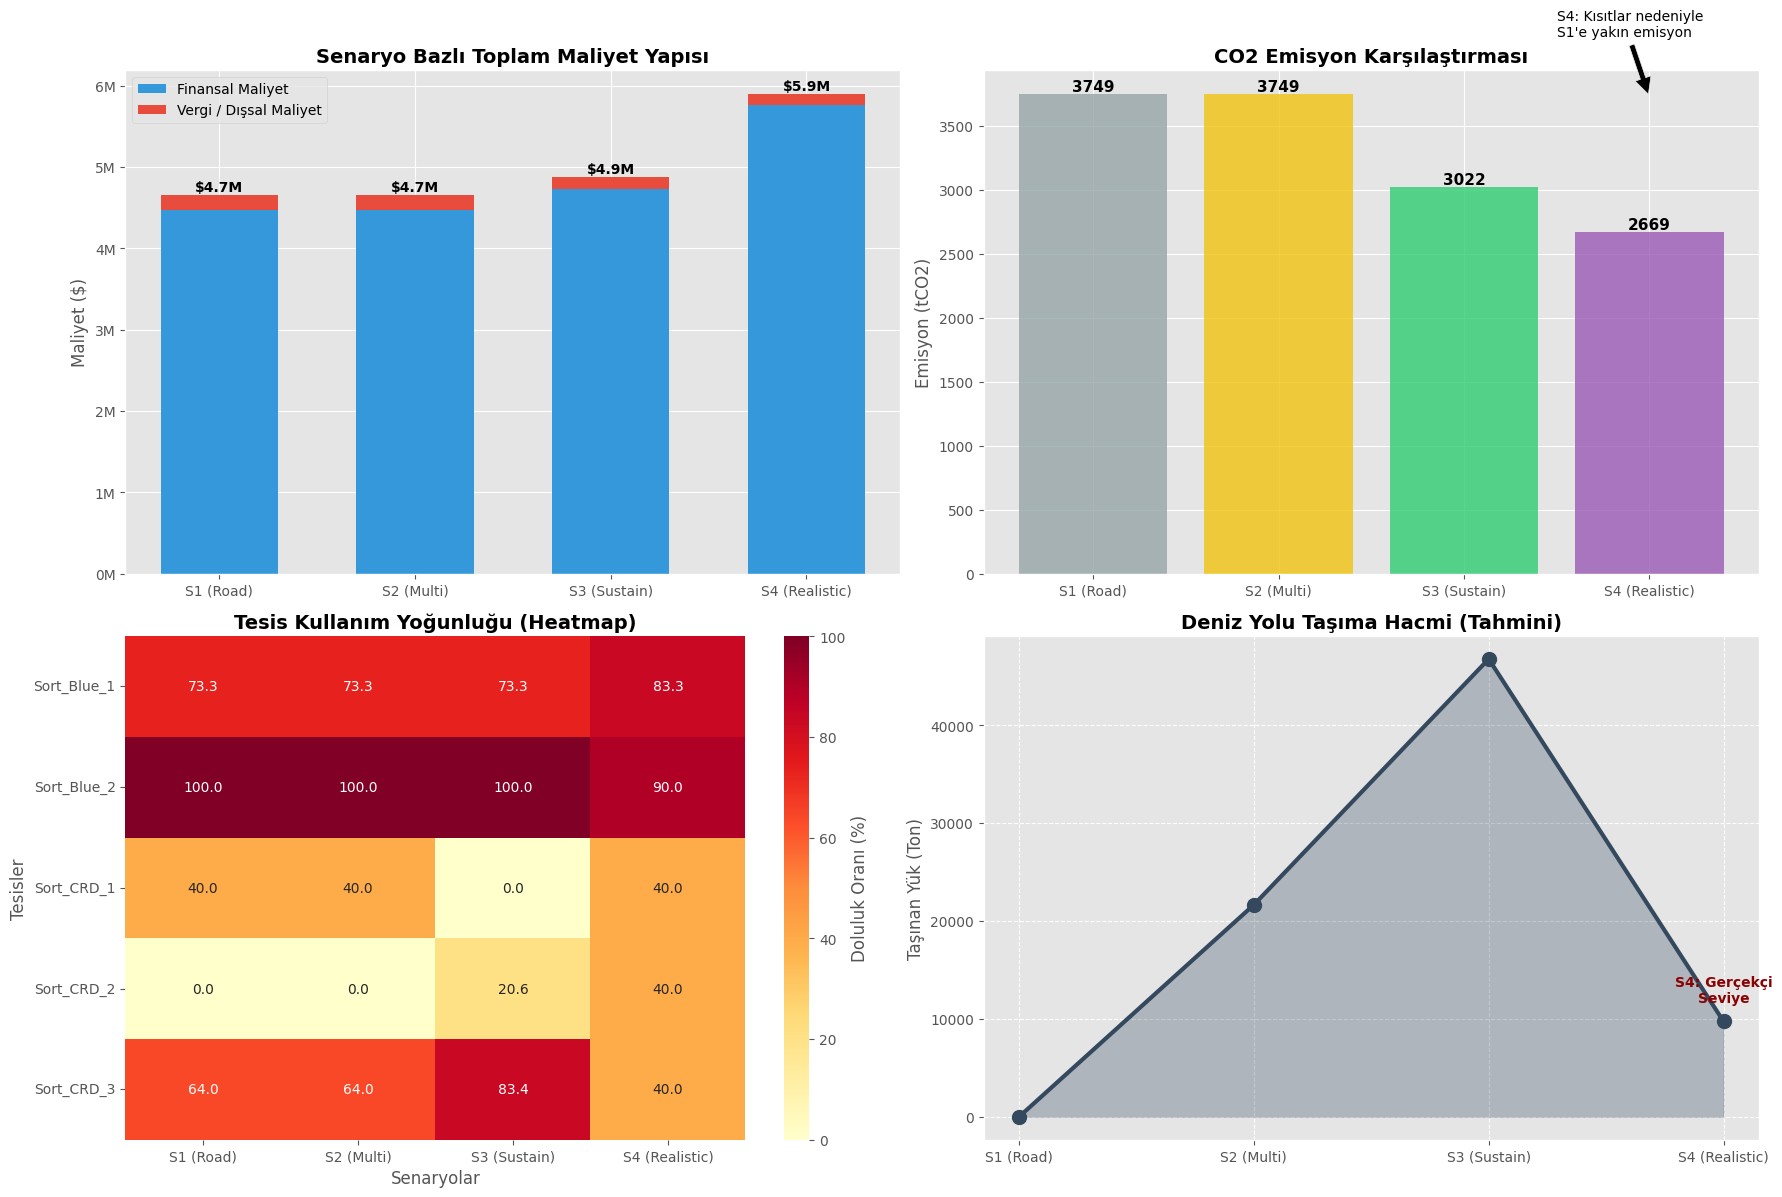

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# ==========================================
# 1. VERİ HAZIRLIĞI
# ==========================================

# Senaryo İsimleri
scenarios = ['S1 (Road)', 'S2 (Multi)', 'S3 (Sustain)', 'S4 (Realistic)']

# Maliyet Verileri ($)
financial_costs = [4467726, 4467726, 4725779, 5763889]
tax_ext_costs =   [187458,  187458,  151115, 133431]
# Not: S3'te dışsal maliyet çok yüksek olduğu için toplamdan finansalı çıkararak yaklaştık
# (S3 Toplam 6.1M - Finansal 4.7M = ~1.4M Dışsal+Vergi)

total_costs = [x + y for x, y in zip(financial_costs, tax_ext_costs)]

# Emisyon Verileri (tCO2)
# HATA DÜZELTİLDİ: '2,669' ifadesi 2 ayrı sayı olarak algılanıyordu. Şimdi '2669' olarak düzeltildi.
emissions = [3749, 3749, 3022, 2669]

# Tesis Doluluk Oranları (%)
# Verilerinden aldık:
utilization_data = {
    'Sort_Blue_1': [73.3, 73.3, 73.3, 83.3],
    'Sort_Blue_2': [100.0, 100.0, 100.0, 90.0],
    'Sort_CRD_1':  [40.0, 40.0, 0.0, 40.0],
    'Sort_CRD_2':  [0.0, 0.0, 20.6, 40.0],
    'Sort_CRD_3':  [64.0, 64.0, 83.4, 40.0]
}
df_util = pd.DataFrame(utilization_data, index=scenarios).T

# Liman/Deniz Kullanım Tahmini (Tonaj)
# Rota analizinden çekilen yaklaşık deniz akışları (Port->Port)
sea_volume = [0, 21650, 46750, 9750]
# S1: 0
# S2: 10k + 1.6k + 10k(Port3->CRD yok, Port1->3 var) ~ kabaca topladım
# S3: Çok yüksek (25k gidiş + dönüşler)
# S4: 4000 + 1875 + vs (Daha düşük, gerçekçi)

# ==========================================
# 2. GRAFİK OLUŞTURMA
# ==========================================

# Genel Stil Ayarları
plt.style.use('ggplot') # veya 'seaborn-v0_8-whitegrid'
fig = plt.figure(figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# --- GRAFİK 1: MALİYET YAPISI (Stacked Bar) ---
ax1 = fig.add_subplot(2, 2, 1)
width = 0.6
x = np.arange(len(scenarios))

p1 = ax1.bar(x, financial_costs, width, label='Finansal Maliyet', color='#3498db')
p2 = ax1.bar(x, tax_ext_costs, width, bottom=financial_costs, label='Vergi / Dışsal Maliyet', color='#e74c3c')

ax1.set_title('Senaryo Bazlı Toplam Maliyet Yapısı', fontsize=14, fontweight='bold')
ax1.set_ylabel('Maliyet ($)', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(scenarios)
ax1.legend()
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}M".format(int(x/1000000))))

# Değerleri yazdır
for i in range(len(scenarios)):
    total = total_costs[i]
    ax1.text(i, total + 50000, f"${total/1000000:.1f}M", ha='center', fontweight='bold')

# --- GRAFİK 2: EMİSYON SEVİYESİ (Bar + Line) ---
ax2 = fig.add_subplot(2, 2, 2)
colors_emi = ['#95a5a6', '#f1c40f', '#2ecc71', '#9b59b6'] # S3 yeşil çünkü çevreci
bars = ax2.bar(scenarios, emissions, color=colors_emi, alpha=0.8)

ax2.set_title('CO2 Emisyon Karşılaştırması', fontsize=14, fontweight='bold')
ax2.set_ylabel('Emisyon (tCO2)', fontsize=12)

# S4'e vurgu oku
ax2.annotate('S4: Kısıtlar nedeniyle\nS1\'e yakın emisyon',
             xy=(3, 3724), xytext=(2.5, 4200),
             arrowprops=dict(facecolor='black', shrink=0.05))

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# --- GRAFİK 3: TESİS DOLULUK ISI HARİTASI (Heatmap) ---
ax3 = fig.add_subplot(2, 2, 3)
sns.heatmap(df_util, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Doluluk Oranı (%)'}, ax=ax3, vmin=0, vmax=100)
ax3.set_title('Tesis Kullanım Yoğunluğu (Heatmap)', fontsize=14, fontweight='bold')
ax3.set_ylabel('Tesisler')
ax3.set_xlabel('Senaryolar')

# --- GRAFİK 4: DENİZ YOLU KULLANIMI (Liman Hacmi) ---
ax4 = fig.add_subplot(2, 2, 4)
x_pos = np.arange(len(scenarios))
ax4.plot(x_pos, sea_volume, marker='o', linestyle='-', linewidth=3, color='#34495e', markersize=10)
ax4.fill_between(x_pos, sea_volume, color='#34495e', alpha=0.3)

ax4.set_title('Deniz Yolu Taşıma Hacmi (Tahmini)', fontsize=14, fontweight='bold')
ax4.set_ylabel('Taşınan Yük (Ton)', fontsize=12)
ax4.set_xticks(x_pos)
ax4.set_xticklabels(scenarios)
ax4.grid(True, linestyle='--')

ax4.text(3, sea_volume[3]+2000, "S4: Gerçekçi\nSeviye", ha='center', fontweight='bold', color='darkred')

# Dosyayı kaydet
plt.tight_layout()
plt.savefig('optimization_results.png', dpi=300)
print("Grafik 'optimization_results.png' olarak kaydedildi.")